In [29]:
#exploring data downloading functions:
import uavgeo as ug

#downloads by default into relative path from notebook to: "data"
file = ug.load.download("https://zenodo.org/record/8123870/files/ORTHOMOSAIC_230421.jpg", filename = "rgb_ortho.jpg", redownload=True)


data\rgb_ortho.jpg


ORTHOMOSAIC_230421.jpg: 54.1MB [00:29, 1.86MB/s]                                                                       


In [37]:
help(ug.load.download)

Help on function download in module uavgeo.load.download:

download(url, filename=None, redownload=False, output_dir='data', type='')
      Wraps a few libraries together to download (and extract if required) a file from https.
      It outputs the filepath it has stored to.
    
      url     : str 
          url of the file: can be anything in theory, as long as it links directly to the file
      output_dir   : str
          preferred output path, e.g. "data" [default = "data"]
      type    : str 
          subfolder to create based on datatype: e.g."raw", gets appended to output_dir [default = ""]
      filename : str, optional 
          force a filename to store into , please use the correct file-output type, e.g. .zip/.tif./.tar.bz2 [default = None]
      redownload   : str, optional
          force to redownload if the file already exists [default = False].
      
      Returns: output_path of file 
      
      Example
    -------
    
    >>> fname = download("https://fastly

In [31]:
# for example take an orthomosaic image in the folder data:
import os
import zen3geo
import torchdata
import rioxarray as rx

folder_to_search = "data"
filetype = ".jpg"
files = [os.path.join(folder_to_search, item)  for item in os.listdir(folder_to_search) if item.endswith(filetype)]
ortho = rx.open_rasterio(files[0], default_name = "ortho")


C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


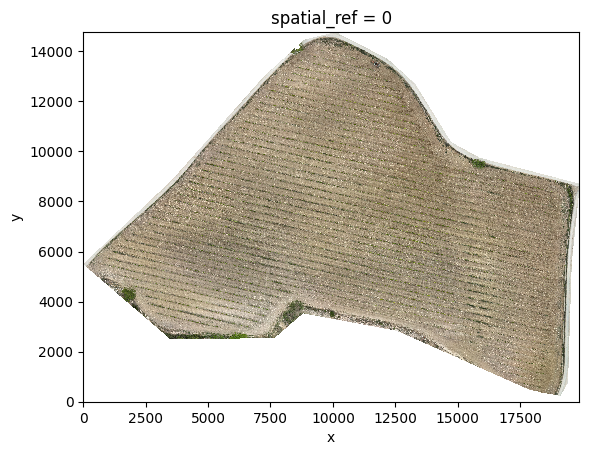

In [20]:
ortho.plot.imshow()

In [32]:
dp = torchdata.datapipes.iter.IterableWrapper(files)
dp_rio = dp.read_from_rioxarray()

In [33]:
dp_xbatcher = dp_rio.slice_with_xbatcher(input_dims = {"x":512, "y":512}, input_overlap={"y": 256, "x": 256})

In [34]:
chips = [chip for chip in dp_xbatcher]
print(f"Number of chips: {len(chips)}")
sample = chips[2600]

C:\Users\judoj\mambaforge\envs\uavgeo\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


Number of chips: 4256


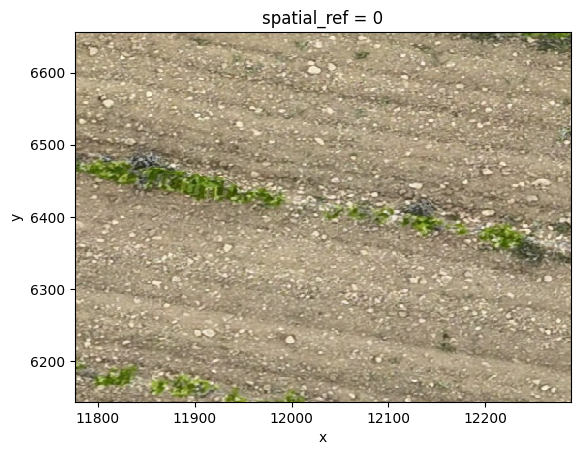

In [35]:
sample.plot.imshow()